#  Here, I calculate one hour prediction by Ensemble Kalman Filter 

### Install weather data to predict

In [1]:
import pandas as pd
import numpy as np
import datetime
import math
import os
import matplotlib.pyplot as plt
from pylab import rcParams

plt.style.use('ggplot')
%pylab inline --no-import-all

#インプットデータ
input_data = pd.read_csv('hakata_ekimae_2017_data_from_meteoblue.csv')
#temp = temp.drop("気温(℃).1",axis=1)
#temp = temp.drop("気温(℃).2" ,axis=1)

#列名の変更
input_data.columns = ['Year', 'Month', 'Day','Hour', 'Minute','Temperature(2m)', 'Mean Sea Level Pressure[hpa]', \
                      'Shortwave Radiation[W/m2]','Wind Speed(10m)[m/s]','Wind Direction(10m)' ,'Wind Speed(80m)[m/s]'\
              , 'Wind Direction(80m)']

#日付型などの変更
input_data['Date'] = input_data[['Year', 'Month', 'Day']].apply(lambda x: '{}@{}@{}'.format(x[0], x[1], x[2]), axis=1)
Date = input_data['Date']
input_data['Date'] =pd.to_datetime(Date, format='%Y@%m@%d')

input_data['Time'] = input_data[['Year', 'Month', 'Day','Hour']].apply(lambda x: '{}@{}@{}@{}'.format(x[0], x[1], x[2],x[3]), axis=1)
Time = input_data['Time']
input_data['Time'] =pd.to_datetime(Time, format='%Y@%m@%d@%H')

#number日分を抽出
number=90
Span = 24*number+1
#Span = 3
ThreeDays = input_data[:Span]
Date = input_data.loc[:,['Time']][:Span+2]
ThreeDays = ThreeDays.loc[:,['Wind Speed(10m)[m/s]', 'Temperature(2m)', 'Wind Speed(80m)[m/s]']]

#時間　気温　日射量をarray型でそれぞれ格納
Wind10 = ThreeDays['Wind Speed(10m)[m/s]'][:Span].values
Temperature = ThreeDays['Temperature(2m)'][:Span].values
Wind80 = ThreeDays['Wind Speed(80m)[m/s]'][:Span].values

Time = Date['Time']


#print(ThreeDays)

#print(Date)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def row(x):    #行
    return x.reshape(1,-1)

def column(x):     #列
    return x.reshape(-1,1)

def row2array(x):
    return x[0,:]

def column2array(x):
    x=x.T
    return x[0,:]

def myoutput(x):   #xには、列ベクトルを入れること
    #rand = np.random.normal(0, 1, (3, 1))
    #dt=0.01
    #x=x + dt*rand
    return column(x)


#時間　気温　日射量をarray型を2D_行ベクトルに変換
x = row(Wind10)
y = row(Temperature)
z = row(Wind80)

### 作成した時間　気温　日射量をarray型を2D_行ベクトルを縦に並べ、以下のような状態ベクトル $ xtr $ を作成する。

### Array type 2D_ row vectors storing created time, temperature and solar radiation are arranged vertically, and the following state vector xtr is created.

$$
    xtr = \left(
        \begin{array}{cccc}
          Hour(0) & Hour(1) & \ldots & Hour(n) \\
          Temperature(0) & Temperature(1) & \ldots & Temperature(n) \\
          Wind Speed(0) & Wind Speed(1) & \ldots & Wind Speed(80m)[m/s](n)
        \end{array}
      \right)
$$

In [3]:
xtr = np.concatenate([x, y, z], axis=0) #行を縦に並べる
ytr =xtr
yt = ytr
len_t = xtr.shape[1]
print(len_t)

2161


### Behavior changes considerably by changing R and Q, so it is necessary to consider.

In [4]:
#分散の初期設定
Rtr = 0.3
###R,Qを変えることで挙動がだいぶ変わってくる
R = np.diag([1, 1, 1]) #3D
Q = np.diag([1, 1, 1])  #3D
#R = np.diag([5, 2, 1]) #3D
#Q = np.diag([3, 4, 3])  #3D

dt = 1
#dt = 0.01

#  EnKFの初期設定
### Mを増やすと安定感が増す。
M = 100  #サンプルの数
barx0 = column(xtr[:,0]) #2D_列ベクトルの状態初期値
P0 = np.diag([1, 3, 3])  #共分散行列の初期値  3D

# アンサンブル行列X_0/tの作成
x0=column(barx0) #2D_列
# アンサンブル行列Y_0/tの作成
y0 = x0 
for i in range(M-1):
        x0_i= barx0 + np.dot(Q,np.random.normal(0, 1, (3, 1))) #2D_列　正規乱数
        x0 = np.concatenate([x0,x0_i],axis=1) #3D_列
        y0_i= myoutput( column(x0[:,0])) + np.dot(R,np.random.normal(0, 1, (3, 1))) 
        y0 = np.concatenate([y0,y0_i],axis=1) #3D_列


In [5]:
#Ensemble Kalman Filterの計算

#誤差アンサンブル行列の作成

Vzero = np.array([[0],[0],[0]])
yest=column(ytr[:,0])
xest0 = column(xtr[:,0])
yest0 = column(ytr[:,0])

for i in range(len_t):
    x=np.array([[0],[0],[0]])
    ### EnKF: 観測更新ステップ ###
    xhat = column(numpy.sum(x0,axis=1) / M ) #2D_列
    yhat = column(numpy.sum(y0,axis=1) / M ) #2D_列
    yest_i = yhat
    yest = np.concatenate([yest,yest_i],axis=1) #3D_列   
    Pxy = np.dot( (np.kron(np.eye(1,M),xhat) - x0), (np.kron(np.eye(1,M),yhat) - y0).T ) / (M-1)  #(3x3)  U 共分散行列
    Pyy = np.dot( (np.kron(np.eye(1,M),yhat) - y0), (np.kron(np.eye(1,M),yhat) - y0).T ) / (M-1)  #(3x3)  V 共分散行列
    K = np.dot(Pxy, np.linalg.inv(Pyy))     #np.linalg.inv(A) Aの逆行列 カルマンゲイン  #(3x3)
    
    ### EnKF: 予測更新ステップ  ###
    for j in range(M-1):
        x_j = column( x0[:,j] + np.dot(K, (yt[:,i] - y0[:,j]) ) ) #2D_列
        x = np.concatenate([x,x_j],axis=1) #3D_列
        x0[:,j] = x[:,j] + column2array(np.dot(Q, np.random.normal(0, 1, (3, 1))) ) #array型
        
        
        y0[:,j] = column2array(  myoutput(column(x0[:,j])) + np.dot(R, np.random.normal(0, 1, (3, 1)) ) )    #array型
     

In [6]:
xtr = np.concatenate([xtr,Vzero],axis=1)
ytr = np.concatenate([ytr,Vzero],axis=1)
xtr = np.concatenate([xtr,Vzero],axis=1)
ytr = np.concatenate([ytr,Vzero],axis=1)
print(yest.shape)
print(ytr.shape)
print(xtr.shape)
print(yest.shape[1])

(3, 2162)
(3, 2163)
(3, 2163)
2162


## 2 step estimation

In [7]:
xtr_2 = np.delete(yest, 0, 1) #行を縦に並べる

ytr_2 =xtr_2
yt_2 = ytr_2
print(xtr_2.shape)
print(xtr_2.shape)

(3, 2161)
(3, 2161)


In [8]:
#  EnKFの初期設定
barx0_2 = column(xtr_2[:,0]) #2D_列ベクトルの状態初期値
#P0 = np.diag([1, 3, 3])  #共分散行列の初期値  3D

# アンサンブル行列X_0/tの作成
x0_2=column(barx0_2) #2D_列
# アンサンブル行列Y_0/tの作成
y0_2 = x0_2 
for i in range(M-1):
        x0_i_2= barx0_2 + np.dot(Q,np.random.normal(0, 1, (3, 1))) #2D_列　正規乱数
        x0_2 = np.concatenate([x0_2,x0_i_2],axis=1) #3D_列
        y0_i_2= myoutput( column(x0_2[:,0])) + np.dot(R,np.random.normal(0, 1, (3, 1))) 
        y0_2 = np.concatenate([y0_2,y0_i_2],axis=1) #3D_列

In [9]:
#Ensemble Kalman Filterの計算

#誤差アンサンブル行列の作成

yest_2=column(ytr_2[:,0])
yest0_2 = column(xtr_2[:,0])
yest0_2 = column(ytr_2[:,0])

for i in range(len_t):
    x_2=np.array([[0],[0],[0]])
    ### EnKF: 観測更新ステップ ###
    xhat_2 = column(numpy.sum(x0_2,axis=1) / M ) #2D_列
    yhat_2 = column(numpy.sum(y0_2,axis=1) / M ) #2D_列
    yest_i_2 = yhat_2
    yest_2 = np.concatenate([yest_2,yest_i_2],axis=1) #3D_列   
    Pxy_2 = np.dot( (np.kron(np.eye(1,M),xhat) - x0_2), (np.kron(np.eye(1,M),yhat) - y0_2).T ) / (M-1)  #(3x3)  U 共分散行列
    Pyy_2 = np.dot( (np.kron(np.eye(1,M),yhat) - y0_2), (np.kron(np.eye(1,M),yhat) - y0_2).T ) / (M-1)  #(3x3)  V 共分散行列
    K_2 = np.dot(Pxy_2, np.linalg.inv(Pyy_2))     #np.linalg.inv(A) Aの逆行列 カルマンゲイン  #(3x3)
    
    ### EnKF: 予測更新ステップ  ###
    for j in range(M-1):
        x_j_2 = column( x0_2[:,j] + np.dot(K_2, (yt_2[:,i] - y0_2[:,j]) ) ) #2D_列
        x_2 = np.concatenate([x_2,x_j_2],axis=1) #3D_列
        x0_2[:,j] = x_2[:,j] + column2array(np.dot(Q, np.random.normal(0, 1, (3, 1))) * dt ) #array型
        
        
        y0_2[:,j] = column2array(  myoutput(column(x0_2[:,j])) + np.dot(R, np.random.normal(0, 1, (3, 1)) ) )    #array型

In [10]:
yest = np.concatenate([yest,Vzero],axis=1) #3D_列

In [11]:

yest_2 = np.concatenate([yest0,yest_2],axis=1) #3D_列
xtr_2 = np.concatenate([xtr_2,Vzero],axis=1)
ytr_2 = np.concatenate([ytr_2,Vzero],axis=1)
print(yest_2.shape)
print(ytr_2.shape)
print(xtr_2.shape)
#yest

(3, 2163)
(3, 2162)
(3, 2162)


In [12]:
## 2 STEP　を1時間前にずらす
#yest_2 = np.delete(yest_2, 0, 1) 
#yest_2 = np.concatenate([yest_2,Vzero],axis=1)


In [16]:
df = pd.DataFrame({ '0Time' : Time,
                    '1xtr1_Wind10' : xtr[0,:],
                    '1xtr2_Temp' : xtr[1,:],
                    '1xtr3_Wind80' : xtr[2,:],
                    '2ytr1_Wind10' : ytr[0,:],
                    '2ytr2_Temp' : ytr[1,:],
                    '2ytr3_Wind80' : ytr[2,:],
                    '3yest1_Wind10' : yest[0,:],
                    '3yest2_Temp' : yest[1,:],
                    '3yest3_Wind80' : yest[2,:],
                    '4step1_Wind10' : yest_2[0,:],
                    '4step2_Temp' : yest_2[1,:],
                    '4step3_Wind80' : yest_2[2,:],
                  })

#df1 = df.set_index(['Time'])

#df[:24]

df = df[24*80:24*83]
#df

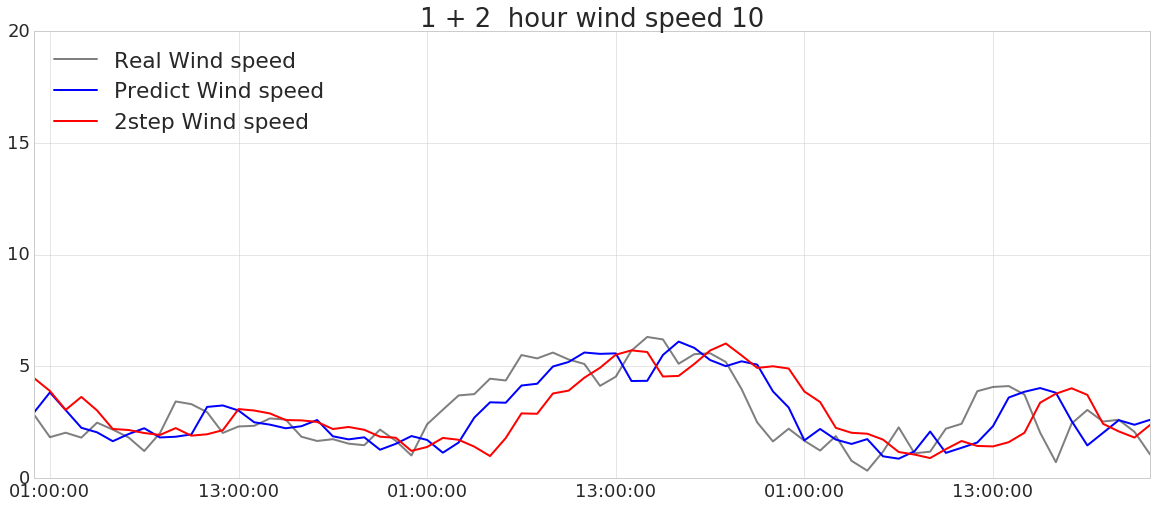

In [17]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
rcParams['figure.figsize'] = 20,8
plt.rcParams["font.size"] = 18

input1 = df['0Time']
output1 = df['1xtr1_Wind10']
output2 = df['3yest1_Wind10']
output3 = df['4step1_Wind10']

fig = plt.figure() 
ax = plt.axes() 

ylim = [0, 20]
ax.set_ylim(ylim)


plt.plot(input1, output1, lw=2, alpha = 0.5, color="black",label="Real Wind speed") #同じfigureの中に追加
plt.plot(input1, output2, lw=2, alpha = 1, color="blue",label="Predict Wind speed") #同じfigureの中に追加
plt.plot(input1, output3, lw=2, alpha = 1, color="red",label="2step Wind speed") #同じfigureの中に追加

plt.title("1 + 2  hour wind speed 10")
plt.legend(loc="upper left")
#plt.savefig("graph_modifcation.png")

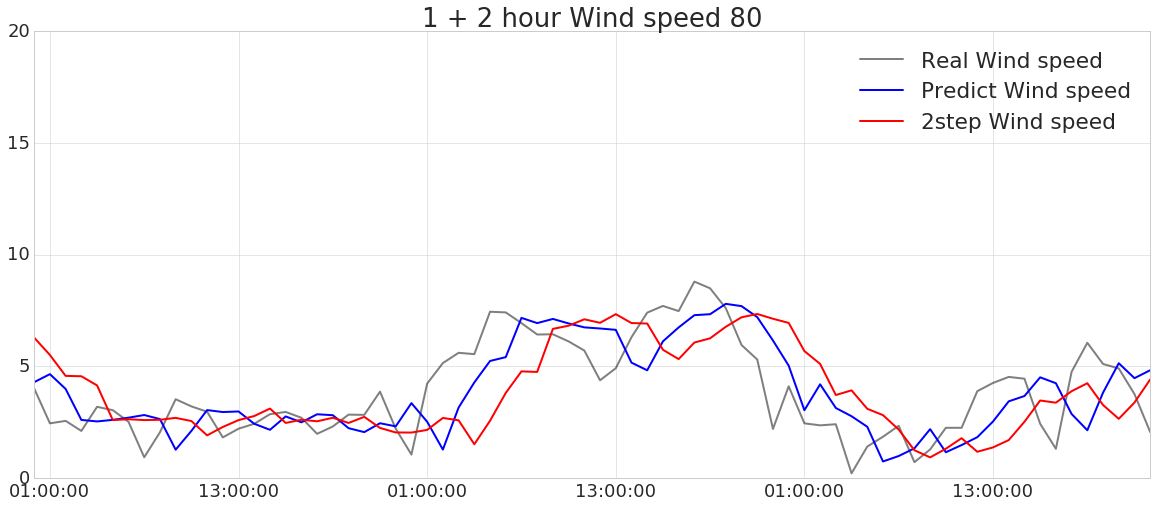

In [18]:
input1 = df['0Time']
output1 = df['1xtr3_Wind80']
output2 = df['3yest3_Wind80']
output3 = df['4step3_Wind80']
fig1 = plt.figure() 
ax1 = plt.axes() 

ylim = [0, 20]
ax1.set_ylim(ylim)


plt.plot(input1, output1, lw=2, alpha = 0.5, color="black",label="Real Wind speed") #同じfigureの中に追加
plt.plot(input1, output2, lw=2, alpha = 1, color="blue",label="Predict Wind speed") #同じfigureの中に追加
plt.plot(input1, output3, lw=2, alpha = 1, color="red",label="2step Wind speed") #同じfigureの中に追加

plt.title("1 + 2 hour Wind speed 80")
plt.legend(loc="upper right")
#plt.savefig("graph_modifcation.png")